# Exoplanet Convolutional Neural Network (CNN) Classifier
Here we will use a CNN to classify if a star observed by Kepler contains a exoplanet 

In [3]:
import tensorflow
import tensorflow.keras.models
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
print(f'Pandas version {pd.__version__}')
print(f'Tensorflow version {tensorflow.__version__}')

Pandas version 1.0.0
Tensorflow version 2.0.0-beta1


First lets load the data and preprocess it.

In [52]:
def load_data(path):
    data = pd.read_csv(path)

    # Convert columns to something more useful.
    for i, column in enumerate(data.columns):
        if 'FLUX' in column:
            data.columns.values[i] = int(column.split('.')[1])
    # Also change labels so 0 is non-exoplanet and 1 is exoplanet
    data.LABEL -= 1
    return data

def normalize_data(df):
    """
    Normalize a Kepler light curve DatFrame with a mean subtraction and 
    """
    # Calculate the mean of each light curve and subtract it
    df_norm = df.copy()
    mean = df_norm.iloc[:, 1:].mean(axis=1)
    df_norm.iloc[:, 1:] = df_norm.iloc[:, 1:].subtract(mean, axis=0)
    # Calculate the standard deviation of each light curve and divide.
    std = df_norm.iloc[:, 1:].std(axis=1)
    df_norm.iloc[:, 1:] = df_norm.iloc[:, 1:].divide(std, axis=0)
    return df_norm


train_data = load_data('./data/exoTrain.csv')
train_data = normalize_data(train_data)

test_data = load_data('./data/exoTest.csv')
test_data = normalize_data(test_data)

Now reshape the arrays to input into the CNN.

In [53]:
train_data_array, train_data_labels = train_data.iloc[:, 1:].values, train_data.iloc[:, 0].values
train_data_array = train_data_array.reshape(*train_data_array.shape, 1)
train_data_labels = train_data_labels.reshape(train_data_labels.shape[0], 1)

test_data_array, test_data_labels = test_data.iloc[:, 1:].values, test_data.iloc[:, 0].values
test_data_array = test_data_array.reshape(*test_data_array.shape, 1)
test_data_labels = test_data_labels.reshape(test_data_labels.shape[0], 1)

print(train_data_array.shape, train_data_labels.shape)
print(test_data_array.shape, test_data_labels.shape)

(5087, 3197, 1) (5087, 1)
(570, 3197, 1) (570, 1)


To ballance the data set we create a batch function to return equal number of exoplanet and non-exoplanet light curves. There will be duplicate light curves.

In [54]:
def light_curve_batch_generator(x, y, batch_size=32):
    """
    Returns equal number of random exoplanets and non-exoplanet detections.
    """
    idx_exo = np.where(y==1)[0]
    idx_nonexo = np.where(y==0)[0]
 
    while True:
        # Randomly pick half exoplanets and half non-exoplanets
        random_idx_exo = np.random.choice(idx_exo, size=batch_size//2, replace=True)
        random_idx_nonexo = np.random.choice(idx_nonexo, size=batch_size//2, replace=True)
        random_idx = np.concatenate((random_idx_exo, random_idx_nonexo))
        np.random.shuffle(random_idx)
        train_data = x[random_idx, :, :]
        train_labels = y[random_idx, :]

        # Shift each lightcurve by a random index. This is a Data Augmentation Technique 
        # to increase the number of observations but will have discontinuities. Without this
        # the CNN will not learn as well.
        for i in range(batch_size):
            random_shift = np.random.randint(train_data.shape[1])
            train_data[i] = np.roll(train_data[i], random_shift, axis=0)
        yield train_data, train_labels

Test the batch generator

In [69]:
batch_gen = light_curve_batch_generator(train_data_array, train_data_labels)
# print(next(batch_gen)) # Uncomment this to see a random output.

In [55]:
model = tensorflow.keras.models.Sequential()
model.add(Conv1D(filters=8, kernel_size=25, activation='relu', input_shape=train_data_array.shape[1:]))
model.add(MaxPooling1D(strides=4))
# model.add(BatchNormalization()) # Normalize to mean=0 and std=1
model.add(Conv1D(filters=16, kernel_size=25, activation='relu'))
model.add(MaxPooling1D(strides=4))
# model.add(BatchNormalization()) # Normalize to mean=0 and std=1
model.add(Conv1D(filters=32, kernel_size=25, activation='relu'))
model.add(MaxPooling1D(strides=4))
# model.add(BatchNormalization()) # Normalize to mean=0 and std=1
model.add(Conv1D(filters=64, kernel_size=25, activation='relu'))
model.add(MaxPooling1D(strides=4))
model.add(Flatten())
# Dropout determines the fraction of the input units to drop. This reduces overfitting 
# https://en.wikipedia.org/wiki/Convolutional_neural_network#Dropout
# model.add(Dropout(0.5)) 
model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [56]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 3173, 8)           208       
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 793, 8)            0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 769, 16)           3216      
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 192, 16)           0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 168, 32)           12832     
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 42, 32)            0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 18, 64)           

In [57]:
model.compile(optimizer=Adam(4e-5), loss='binary_crossentropy', metrics=['accuracy'])

hist = model.fit(x=light_curve_batch_generator(train_data_array, train_data_labels), 
                validation_data=(test_data_array, test_data_labels), 
                verbose=2, epochs=60, steps_per_epoch=train_data_array.shape[0]//32)

Epoch 1/60
158/158 - 13s - loss: 0.6874 - accuracy: 0.5827 - val_loss: 0.6554 - val_accuracy: 0.8228
Epoch 2/60
158/158 - 11s - loss: 0.6410 - accuracy: 0.6517 - val_loss: 0.5802 - val_accuracy: 0.8421
Epoch 3/60
158/158 - 11s - loss: 0.5955 - accuracy: 0.6828 - val_loss: 0.5827 - val_accuracy: 0.7877
Epoch 4/60
158/158 - 11s - loss: 0.5204 - accuracy: 0.7690 - val_loss: 0.3762 - val_accuracy: 0.8877
Epoch 5/60
158/158 - 13s - loss: 0.4645 - accuracy: 0.7981 - val_loss: 0.5036 - val_accuracy: 0.7649
Epoch 6/60
158/158 - 11s - loss: 0.4250 - accuracy: 0.8091 - val_loss: 0.5700 - val_accuracy: 0.7193
Epoch 7/60
158/158 - 12s - loss: 0.3969 - accuracy: 0.8295 - val_loss: 0.4003 - val_accuracy: 0.8281
Epoch 8/60
158/158 - 13s - loss: 0.3616 - accuracy: 0.8495 - val_loss: 0.4538 - val_accuracy: 0.7982
Epoch 9/60
158/158 - 11s - loss: 0.3328 - accuracy: 0.8675 - val_loss: 0.4784 - val_accuracy: 0.7912
Epoch 10/60
158/158 - 11s - loss: 0.3246 - accuracy: 0.8687 - val_loss: 0.4618 - val_accura

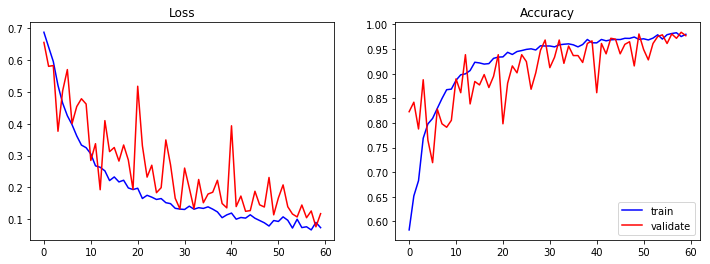

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(hist.history['loss'], color='b')
ax[0].plot(hist.history['val_loss'], color='r')
ax[1].plot(hist.history['accuracy'], color='b', label='train')
ax[1].plot(hist.history['val_accuracy'], color='r', label='validate')
ax[0].set_title('Loss')
ax[1].set_title('Accuracy')
ax[1].legend();
plt.savefig('cnn_without_batch_normalization.png')

In [59]:
model.evaluate(test_data_array, test_data_labels, verbose=2)

570/570 - 0s - loss: 0.1181 - accuracy: 0.9772


[0.11808434791470829, 0.977193]

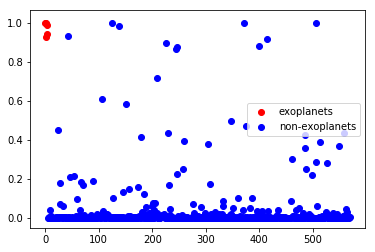

In [60]:
exo_idx = np.where(test_data_labels == 1)[0]
nonexo_idx = np.where(test_data_labels == 0)[0]
cnn_predict = model.predict(test_data_array)

plt.scatter(exo_idx, cnn_predict[exo_idx].flatten(), c='r', label='exoplanets')
plt.scatter(nonexo_idx, cnn_predict[nonexo_idx].flatten(), c='b', label='non-exoplanets')
plt.legend();